In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Activation, add

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, MeanSquaredError

from tensorflow.keras import backend as K

sns.set_theme(style='darkgrid', palette='pastel')

In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


In [23]:
print("Dataset downloaded to:", path)


Dataset downloaded to: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


In [27]:
# images and masks folder paths
img_dir = f"{path}/images"
mask_dir = f"{path}/masks"

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

In [28]:
image_names = [os.path.splitext(f)[0] for f in img_files]    # ('ISIC_0024306', '.jpg')
mask_names = [os.path.splitext(f)[0].replace('_segmentation', '') for f in mask_files]    # ('ISIC_0024306_segmentation', 'png')

missing_masks = [f for f in image_names if f not in mask_names]

if len(missing_masks) == 0:
    print('No missing masks found.')
else:
    print(f"There are {len(missing_masks)} missing masks found:")
    print(missing_masks)

No missing masks found.


In [10]:
len(image_files), len(mask_files)

(10015, 10015)

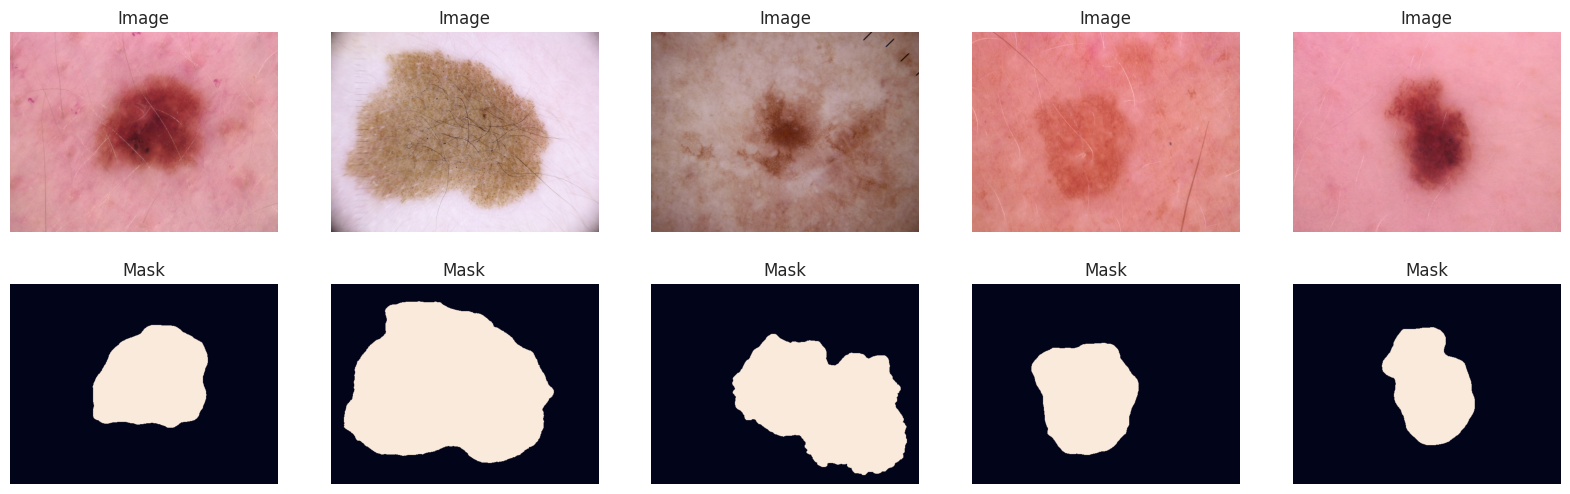

In [29]:
def display_image_and_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(2, n, figsize=(20, 6))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(img_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')

        axs[1, i].imshow(mask)
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')

plt.show()
display_image_and_mask(n=5, seed=42)

In [30]:
def display_image_with_mask(n=5, seed=None):
    if seed:
        np.random.seed(seed)

    fig, axs = plt.subplots(1, n, figsize=(20, 5))
    for i in range(n):
        idx = np.random.randint(0, len(img_files))
        img_path = os.path.join(img_dir, img_files[idx])
        mask_path = os.path.join(mask_dir, os.path.splitext(img_files[idx])[0] + '_segmentation.png')    # mask_files[idx]

        img_np = np.array(Image.open(img_path))
        mask_np = np.array(Image.open(mask_path))

        axs[i].imshow(img_np)
        axs[i].imshow(mask_np, cmap='Reds', alpha=0.5)
        axs[i].set_title('Image with Mask')
        axs[i].axis('off')

plt.show()

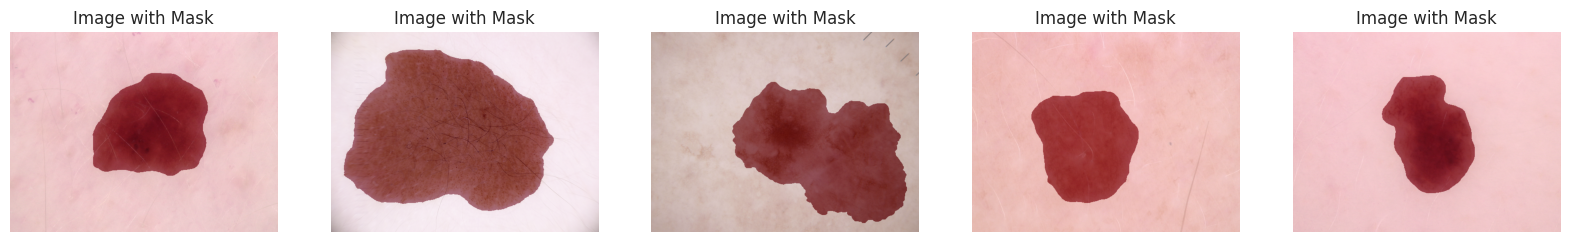

In [31]:
display_image_with_mask(n=5, seed=42)

In [44]:
IMG_SIZE = 256
BATCH_SIZE = 32
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [45]:
def img_mask_paths(img_dir, mask_dir):
    img_path = sorted(gb.glob(os.path.join(img_dir, '*.jpg')))
    mask_path = sorted(gb.glob(os.path.join(mask_dir, '*.png')))
    return np.array(img_path), np.array(mask_path)

imgs_path, masks_path = img_mask_paths(img_dir, mask_dir)

In [46]:
X_train, X_temp, y_train, y_temp = train_test_split(imgs_path, masks_path, train_size=0.90, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

In [47]:
print(f"{'Training:':<15}{len(X_train)}")
print(f"{'Validation:':<15}{len(X_val)}")
print(f"{'Testing:':<15}{len(X_test)}")

Training:      9013
Validation:    501
Testing:       501


In [48]:
def map_fn(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0

    return img, mask

In [49]:
# train_set
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(map_fn, num_parallel_calls=AUTOTUNE)
train_set = train_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# val_set
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(map_fn, num_parallel_calls=AUTOTUNE)
val_set = val_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# test_set
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(map_fn, num_parallel_calls=AUTOTUNE)
test_set = test_set.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [50]:
# U-Net Model
def UNET():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = Conv2D(32, 3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    skip_connections = []

    # Encoder
    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        skip_connections.append(x)
        x = MaxPooling2D(2, strides=2, padding='same')(x)

    # Bottleneck
    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1024, 3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    for filters in [512, 256, 128, 64]:
        x = Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        skip_connection = skip_connections.pop()
        x = add([x, skip_connection])

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters, 3, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    outputs = Conv2D(1, 1, strides=1, activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [51]:
model = UNET()

In [52]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 256, 256, 32)   │            128 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_38             │ (None, 256, 256, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ activation_38[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 256, 256, 64)   │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_39             │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_39[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 256, 256, 64)   │            256 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 256, 256, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 64)   │              0 │ activation_40[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 128, 128, 128)  │            512 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 128, 128, 128)  │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)   

 Total params: 27,939,585 (106.58 MB)

 Trainable params: 27,927,745 (106.54 MB)

 Non-trainable params: 11,840 (46.25 KB)

In [53]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [54]:
model.compile(optimizer=Adam(0.0002),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), dice_coefficient])

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, add
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [57]:
checkpoint_cb = ModelCheckpoint('best_weights.weights.h5',
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=5,
                                 verbose=1)

In [58]:
history = model.fit(train_set, epochs=10, validation_data=val_set, callbacks=[checkpoint_cb, reduce_lr_cb])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_158']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8881 - dice_coefficient: 0.6992 - loss: 0.2828 - precision: 0.8095 - recall: 0.7935
Epoch 1: val_loss improved from inf to 0.61409, saving model to best_weights.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.8882 - dice_coefficient: 0.6994 - loss: 0.2826 - precision: 0.8098 - recall: 0.7937 - val_accuracy: 0.6991 - val_dice_coefficient: 0.6117 - val_loss: 0.6141 - val_precision: 0.4822 - val_recall: 0.9847 - learning_rate: 2.0000e-04
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9428 - dice_coefficient: 0.8313 - loss: 0.1487 - precision: 0.9199 - recall: 0.8716
Epoch 2: val_loss improved from 0.61409 to 0.19950, saving model to best_weights.weights.h5
282/282 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.9428 - dice_coefficient: 0.8314 - loss: 0.1486 - precision: 0.9200 - recall: 0.8716 - val_accuracy: 0.9217 - val_dice_coefficient: 0.8312 - val_loss: 0.1995 - val_precision: 0.8148 - val_reca

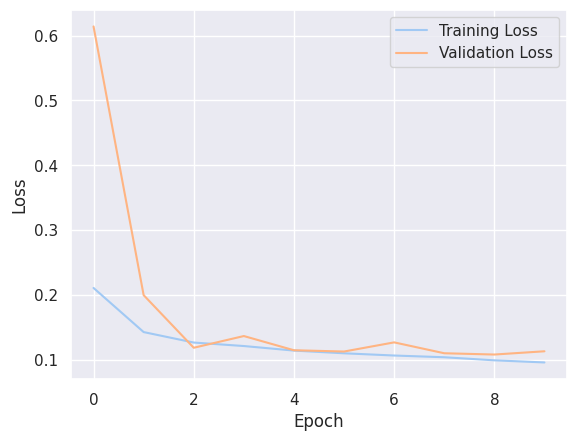

In [59]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

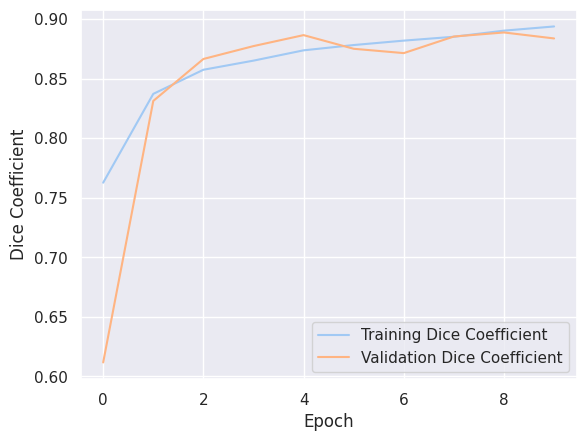

In [60]:
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

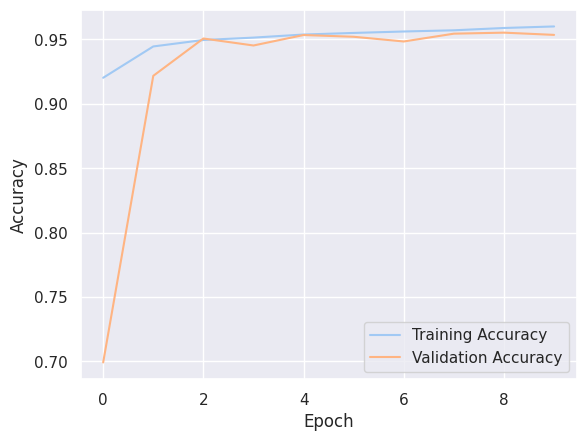

In [61]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
loss, accuracy, precision, recall, dice_coefficient = model.evaluate(test_set)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test Dice Coefficient: {dice_coefficient:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 498ms/step - accuracy: 0.9540 - dice_coefficient: 0.8869 - loss: 0.1139 - precision: 0.9069 - recall: 0.9423
Test Loss: 0.1145
Test Accuracy: 0.9541
Test Precision: 0.9064
Test Recall: 0.9431
Test Dice Coefficient: 0.8875


In [63]:
print(f"{'Test Loss:':<25}{loss:.4f}")
print(f"{'Test Accuracy:':<25}{accuracy:.4f}")
print(f"{'Test Precision:':<25}{precision:.4f}")
print(f"{'Test Recall:':<25}{recall:.4f}")
print(f"{'Test Dice Coefficient:':<25}{dice_coefficient:.4f}")

Test Loss:               0.1145
Test Accuracy:           0.9541
Test Precision:          0.9064
Test Recall:             0.9431
Test Dice Coefficient:   0.8875


In [68]:
x_testsample , y_testsample = next(iter(test_set))

In [69]:
 y_pred = model.predict(x_testsample)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_158']
Received: inputs=Tensor(shape=(32, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [70]:
def draw(test_images , test_masks , y_preds):

    plt.figure(figsize = (20, 10))
    index = 0
    n = np.random.randint(y_preds.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            plt.imshow(test_images[n])
            plt.imshow(test_images[n])
            plt.title('Original Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            plt.imshow(test_masks[n])
            plt.imshow(test_masks[n], alpha = 0.2, cmap = 'jet')
            plt.title('Original Mask')
            index = 2
            plt.axis('off')
        elif index == 2 :
            plt.imshow(test_masks[n])
            plt.imshow(y_preds[n], alpha = 0.2, cmap = 'jet')
            plt.title('Predict Mask')
            index = 0
            n = np.random.randint(y_preds.shape[0])
            plt.axis('off')


    plt.legend()

<ipython-input-70-a0a093ebfeb8>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


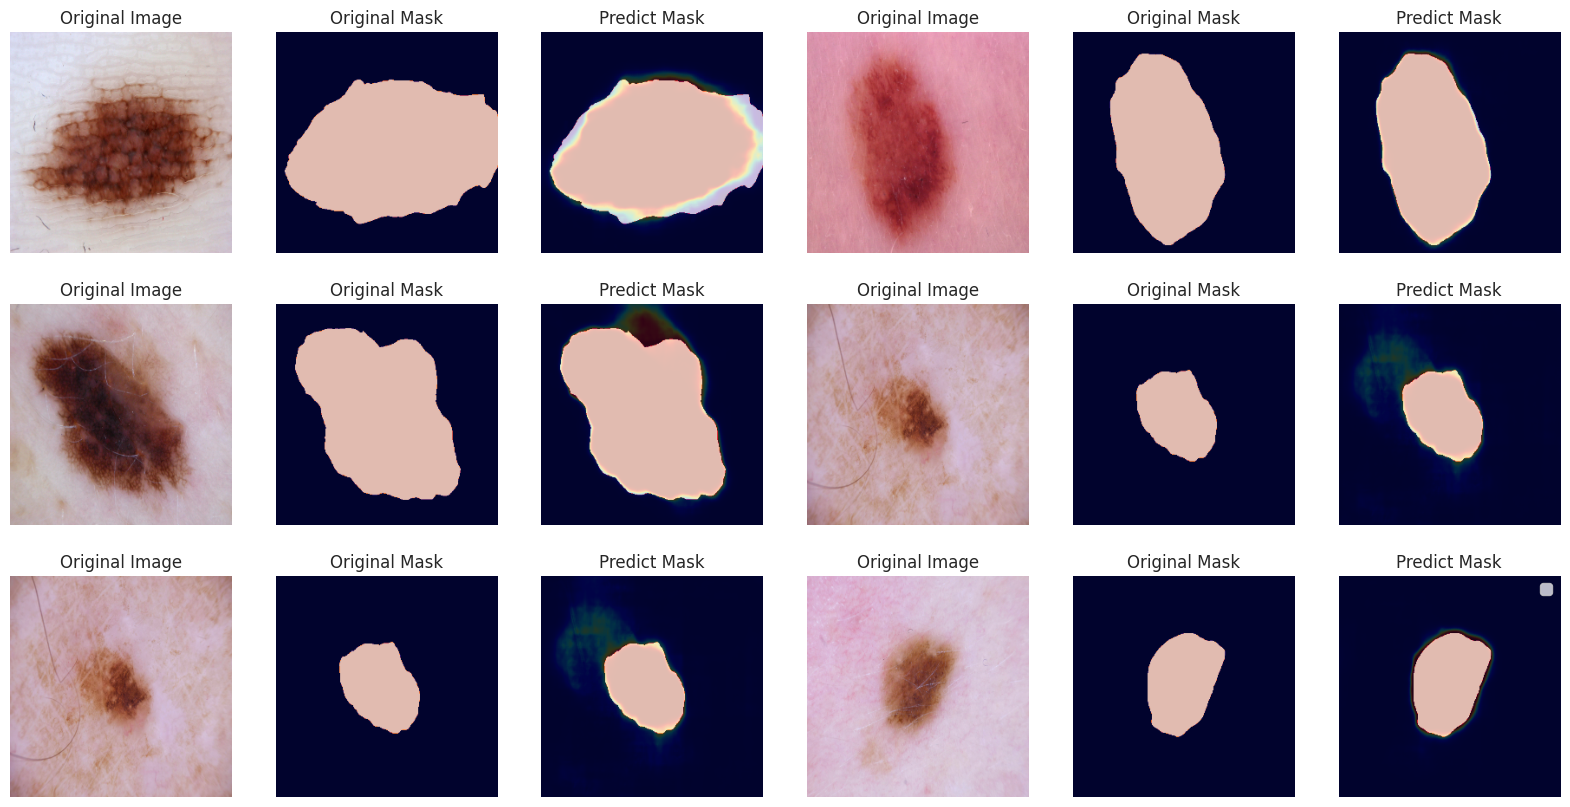

In [71]:
draw(x_testsample, y_testsample , y_pred)